# Сегментация изображений

В этом ноутбуке рассмотрим задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

## Загрузка данных

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
 
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
 
from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
 
from PIL import Image, ImageEnhance
 
import os
 
import random
 
from tqdm.notebook import tqdm
 
import time
 
import pandas as pd

## Модуль аугментации

In [ ]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.images_list = sorted(os.listdir(images_dir), \
                                  key=lambda x: int(x[:x.find('.')]))
        self.target_list = sorted(os.listdir(target_dir), \
                                  key=lambda x: int(x[:x.find('.')]))
        self.transforms = transforms
        
    def __len__(self):
        return len(os.listdir(self.images_dir))
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        image = Image.open(self.images_dir + self.images_list[idx])
        mask = None
        if self.target_dir is not None:
            mask = Image.open(self.target_dir + self.target_list[idx])
        sample = {'img': image, 'mask': mask}
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample['img'], sample['mask']

В данной части реализуем следующие трансформеры:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [ ]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
 
    def __call__(self, sample):
        """
        Args:
            sample {'img': PIL.Image, 'mask': PIL.Image}: Image to be flipped and its mask.
 
        Returns:
            {'img': PIL.Image, 'mask': PIL.Image}: Randomly flipped image and its mask.
        """
        if self.p > random.random():
            if sample['mask'] is not None:
                return {'img': sample['img'].transpose(Image.FLIP_LEFT_RIGHT), \
                            'mask': sample['mask'].transpose(Image.FLIP_LEFT_RIGHT)}
            return {'img': sample['img'].transpose(Image.FLIP_LEFT_RIGHT), \
                        'mask': None}
        return sample
 
 
class RandomCrop(object):
    def __init__(self, p=0.5, crop_size=None):
        self.p = p
        self.crop_size = crop_size
 
    def __call__(self, sample):
        """
        Args:
            sample ({'img': PIL.Image, 'mask': PIL.Image}): image to be cropped and its mask.
 
        Returns:
            {'img': PIL.Image, 'mask': PIL.Image}: randomly cropped image and its mask.
        """
        if self.p > random.random():
            img_w, img_h = sample['img'].size
            if self.crop_size is None:
                crop_w = random.randint(1, img_w)
                crop_h = random.randint(1, img_h)
            else:
                crop_w = self.crop_size[0]
                crop_h = self.crop_size[1]
            crop_x = random.randint(0, img_w - crop_w)
            crop_y = random.randint(0, img_h - crop_h)
            crop_coords = (crop_x, crop_y, crop_x + crop_w, crop_y + crop_h)
            if sample['mask'] is not None:
                return {'img': sample['img'].crop(crop_coords).resize((img_w, img_h)), \
                            'mask': sample['mask'].crop(crop_coords).resize((img_w, img_h))}
            return {'img': sample['img'].crop(crop_coords).resize((img_w, img_h)), \
                        'mask': sample['mask']}
        return sample
 
 
class RandomBackgroundChange(object):
    def __init__(self, img_list, p=0.5):
        self.p = p
        self.bg_list = img_list
 
    def __call__(self, sample):
        """
        Args:
            sample {'img': PIL.Image, 'mask': PIL.Image}: Image to change background of and its mask.
 
        Returns:
            PIL.Image: Randomly background changed image.
        """
        if self.p > random.random():
            bg_img = Image.open(self.bg_list[random.randint(0, len(self.bg_list) - 1)])
            return {'img': Image.composite(sample['img'], bg_img, sample['mask']), 'mask': sample['mask']}
        return sample
 
 
class RandomBrightnessAdjustment(object):
    def __init__(self, p=0.5, factor=None):
        self.p = p
        self.factor = factor
 
    def __call__(self, sample):
        """
        Args:
            sample {'img': PIL.Image, 'mqdk: PIL.Image}: Image to adjust brightness on and its mask.
 
        Returns:
            PIL.Image: Image with randomly adjusted brightness.
        """
        if self.p > random.random():
            factor = self.factor
            if factor is None:
                factor = random.uniform(0.0, 2.0)
            return {'img': ImageEnhance.Brightness(sample['img']).enhance(factor), 'mask': sample['mask']}
        return sample

Добавим случайные преобразования в датасеты, а также преобразование в tensor и нормализацию для изображения:
 
```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [ ]:
class ImageToTensor(object):
    def __call__(self, sample):
        img = ToTensor()(sample['img'])
        mask = None
        if sample['mask'] is not None:
            mask = torch.as_tensor(np.array(sample['mask']), dtype=torch.int64)
        return {'img': img, 'mask': mask}
 
 
class ImageNormalizer(object):
    def __call__(self, sample):
        normalizer = Normalize(mean=[0.485, 0.456, 0.406], \
                               std=[0.229, 0.224, 0.225])
        if sample['mask'] is None:
            return {'img': normalizer(sample['img']), 'mask': sample['mask']}
        return {'img': normalizer(sample['img']), 'mask': sample['mask'] / 255}
 
 
DATA_PATH = './people_data/'
 
train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=Compose([RandomHorizontalFlip(), \
                        RandomBackgroundChange([DATA_PATH + 'train/' + \
                                                img_dir for img_dir in \
                                                os.listdir(DATA_PATH + 'train/')]), \
                        RandomCrop(), \
                        RandomBrightnessAdjustment(), \
                        ImageToTensor(), \
                        ImageNormalizer()])
)
 
test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=Compose([ImageToTensor(), \
                        ImageNormalizer()])
)

Функция для отображения изображения:

In [ ]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]
 
    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)
 
    mask_to_show = mask_img[1].numpy()
 
    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)
 
 
    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')
 
    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразим несколько изображений и масок, на которых будет видна правильная работа модуля аугментации данных.

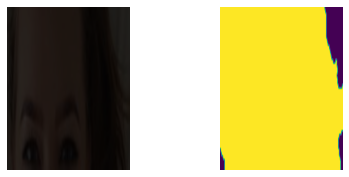

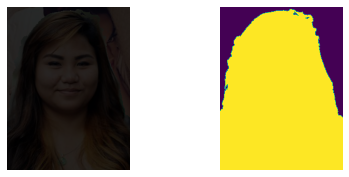

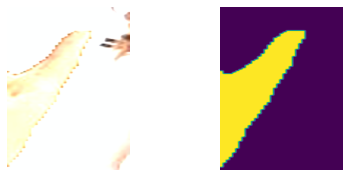

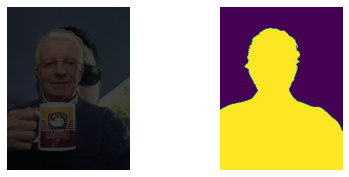

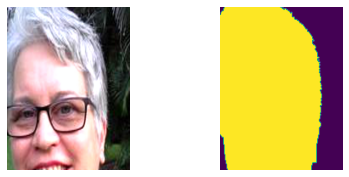

In [ ]:
for i in range(5):
    show_idx_image(train_dataset, i)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками.

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=20)

## DiceLoss

Результат dice loss определим как:
 
$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$
 
где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

Проверка реализации:

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.float()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        dice_loss_value  = 1 - 2 * torch.sum(logits * true_labels, (1, 2)) / \
          torch.sum(logits + true_labels + self.eps, (1, 2))
        
        if self.reduction == 'sum':
            loss_value = torch.sum(dice_loss_value)
        elif self.reduction == 'mean':
            loss_value = torch.mean(dice_loss_value)
        elif self.reduction is None:
            loss_value = dice_loss_value
            
        return loss_value

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])
 
target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])
 
losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)
 
loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)
 
loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))
 
    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
 
        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()
 
        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))
 
    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )
 
    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [ ]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()
 
    loss = 0.
    correct = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to(device)
            loss += float(criterion(outputs, torch.unsqueeze(labels, 1).type_as(outputs)).detach())
            correct += float(val_criterion(outputs, torch.unsqueeze(labels, 1).type_as(outputs)).detach())
    
    mean_loss = loss / len(testloader)
    metric = correct / len(testloader)
    
    return mean_loss, metric

Теперь применим сеть на практике.
 
Обучим её на обучающей выборке и протестируем качество на тестовой выборке. 
 
Сначала при обучении будем использовать только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируем результат.
 
Сравним между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 
 
Для всех экспериментов отобразим графики функции потерь и качества за время обучения. Выведем получившиеся маски для нескольких изображений из датасета. Сделаем выводы.

In [ ]:
class DiceScore(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.float()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        dice_score_value  = 2 * torch.sum(logits * true_labels, (1, 2)) / \
          torch.sum(logits + true_labels + self.eps, (1, 2))
        
        if self.reduction == 'sum':
            score_value = torch.sum(dice_score_value)
        elif self.reduction == 'mean':
            score_value = torch.mean(dice_score_value)
        elif self.reduction is None:
            score_value = dice_score_value
            
        return score_value

In [ ]:
def train(model, train_dataloader, test_dataloader, optimizer, \
              criterion, val_criterion, num_epoch, device):
    model = model.to(device)
    train_loss_on_epoch = []
    test_loss_on_epoch = []
    train_metric_on_epoch = []
    test_metric_on_epoch = []
    for epoch in tqdm(range(num_epoch)):
        model.train()
        cur_train_loss = 0.
        cur_train_metric = 0.
        n_batches = len(train_dataloader)
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, torch.unsqueeze(labels, 1).type_as(outputs))
            loss.backward()
            optimizer.step()
            cur_train_loss += float(loss.detach())
            cur_train_metric += float(val_criterion(outputs, \
                                torch.unsqueeze(labels, 1).type_as(outputs)).detach())

        train_loss_on_epoch.append(cur_train_loss / n_batches)
        train_metric_on_epoch.append(cur_train_metric / n_batches)
        cur_test_loss, cur_test_metric = evaluate_net(model, test_dataloader, \
                                         criterion, val_criterion, device)
        test_loss_on_epoch.append(cur_test_loss)
        test_metric_on_epoch.append(cur_test_metric)
        print('epoch: {}, train/test loss: {}/{}, train/test metric: {}/{}'.format(epoch, \
                                                                                   train_loss_on_epoch[-1], \
                                                                                   test_loss_on_epoch[-1], \
                                                                                   train_metric_on_epoch[-1], \
                                                                                   test_metric_on_epoch[-1]))
    return train_loss_on_epoch.copy(), train_metric_on_epoch.copy(), \
           test_loss_on_epoch.copy(), test_metric_on_epoch.copy()

In [ ]:
lr = 1e-4
weight_decay = 0
num_epoch = 30

In [ ]:
val_criterion = DiceScore(reduction='mean')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
unet_ce = UNet()
optimizer_unet_ce = optim.Adam(unet_ce.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
 
start_time = time.time()
unet_ce_train_loss_on_epoch, \
  unet_ce_train_metric_on_epoch, \
  unet_ce_test_loss_on_epoch, \
  unet_ce_test_metric_on_epoch = \
    train(unet_ce, train_data_loader, test_data_loader, \
          optimizer_unet_ce, criterion, val_criterion, num_epoch, device)
unet_ce_fitting_time = time.time() - start_time

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


epoch: 0, train/test loss: 0.4744531395534674/0.2596133760583233, train/test metric: 0.6620118956212644/0.7603755135771254
epoch: 1, train/test loss: 0.37436813907490835/0.26587610177590815, train/test metric: 0.7146536251792202/0.7426236574078949
epoch: 2, train/test loss: 0.348357447595508/0.28213808895416664, train/test metric: 0.7285676064314666/0.7905147558366749
epoch: 3, train/test loss: 0.32074457245844384/0.2642226063869369, train/test metric: 0.7446354795054153/0.7743056177253455
epoch: 4, train/test loss: 0.31440390788846545/0.19651489757316212, train/test metric: 0.743022115694152/0.8000465921113189
epoch: 5, train/test loss: 0.30551841604488866/0.19189177778824953, train/test metric: 0.7445953010188209/0.8145838228749557
epoch: 6, train/test loss: 0.31264563163673437/0.2655232644207041, train/test metric: 0.7445957102157451/0.7870027914013661
epoch: 7, train/test loss: 0.2962892602549659/0.20039327699743525, train/test metric: 0.7548877668380737/0.8233543286021326
epoch: 8

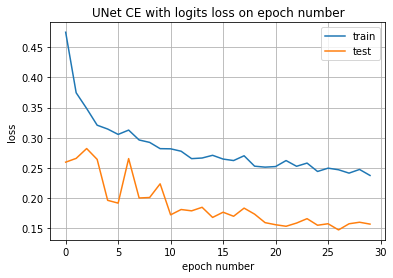

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('UNet CE with logits loss on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('loss')
ax.plot(list(range(num_epoch)), unet_ce_train_loss_on_epoch, label='train')
ax.plot(list(range(num_epoch)), unet_ce_test_loss_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

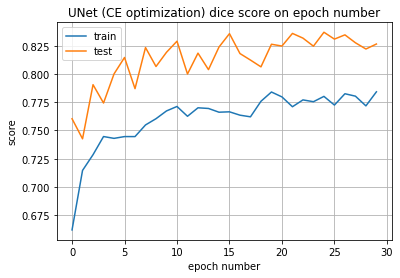

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('UNet (CE optimization) dice score on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('score')
ax.plot(list(range(num_epoch)), unet_ce_train_metric_on_epoch, label='train')
ax.plot(list(range(num_epoch)), unet_ce_test_metric_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

Предсказания UNet с CE loss:

[]

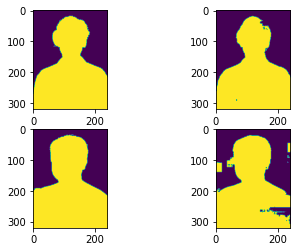

In [ ]:
unet_ce.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_data_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = unet_ce(inputs)
    preds = torch.sigmoid(preds)
    pred1 = (torch.squeeze(preds[0].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label1 = labels[0].cpu().data.numpy()
    pred2 = (torch.squeeze(preds[1].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label2 = labels[1].cpu().data.numpy()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(label1)
    ax2.imshow(pred1)
    ax3.imshow(label2)
    ax4.imshow(pred2)
plt.plot()

In [ ]:
lr = 5e-5
weight_decay = 1e-4
num_epoch = 30
 
unet_dice = UNet()
optimizer_unet_dice = optim.Adam(unet_dice.parameters(), lr=lr, weight_decay = weight_decay)
criterion = DiceLoss(reduction='mean')
 
start_time = time.time()
unet_dice_train_loss_on_epoch, \
  unet_dice_train_metric_on_epoch, \
  unet_dice_test_loss_on_epoch, \
  unet_dice_test_metric_on_epoch = \
    train(unet_dice, train_data_loader, test_data_loader, \
          optimizer_unet_dice, criterion, val_criterion, num_epoch, device)
unet_dice_fitting_time = time.time() - start_time

epoch: 0, train/test loss: 0.3371914476156235/0.2981180027127266, train/test metric: 0.6628085799953517/0.7018820568919182
epoch: 1, train/test loss: 0.3010106189724277/0.2981180027127266, train/test metric: 0.6989894062280655/0.7018820568919182
epoch: 2, train/test loss: 0.289422906935215/0.2981180027127266, train/test metric: 0.7105771233053768/0.7018820568919182
epoch: 3, train/test loss: 0.2988807311391129/0.2981180027127266, train/test metric: 0.7011192958144581/0.7018820568919182
epoch: 4, train/test loss: 0.29370471572174744/0.2981180027127266, train/test metric: 0.7062953079448027/0.7018820494413376
epoch: 5, train/test loss: 0.2926465279477484/0.2981180027127266, train/test metric: 0.7073534919935114/0.7018820494413376
epoch: 6, train/test loss: 0.2935262686189483/0.2981180064380169, train/test metric: 0.7064737554858712/0.7018820345401764
epoch: 7, train/test loss: 0.2854909508982125/0.2981180213391781, train/test metric: 0.7145090734257418/0.7018819898366928
epoch: 8, train/

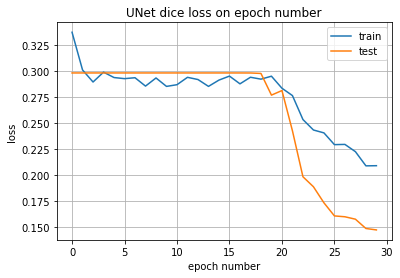

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('UNet dice loss on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('loss')
ax.plot(list(range(num_epoch)), unet_dice_train_loss_on_epoch, label='train')
ax.plot(list(range(num_epoch)), unet_dice_test_loss_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

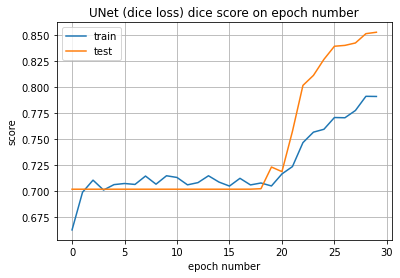

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('UNet (dice loss) dice score on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('score')
ax.plot(list(range(num_epoch)), unet_dice_train_metric_on_epoch, label='train')
ax.plot(list(range(num_epoch)), unet_dice_test_metric_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

Предсказания UNet с dice loss

[]

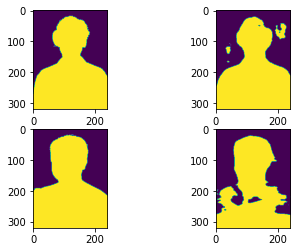

In [ ]:
unet_dice.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_data_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = unet_dice(inputs)
    preds = torch.sigmoid(preds)
    pred1 = (torch.squeeze(preds[0].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label1 = labels[0].cpu().data.numpy()
    pred2 = (torch.squeeze(preds[1].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label2 = labels[1].cpu().data.numpy()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(label1)
    ax2.imshow(pred1)
    ax3.imshow(label2)
    ax4.imshow(pred2)
plt.plot()

In [ ]:
class WeightedLoss(nn.Module):
    def __init__(self, loss_1, loss_2, w1, w2):
        super().__init__()
        self.loss_1 = loss_1
        self.loss_2 = loss_2
        self.w1 = w1
        self.w2 = w2

    def forward(self, logits, true_labels):
        loss_value = self.w1 * self.loss_1(logits, true_labels) + \
                     self.w2 * self.loss_2(logits, true_labels)
 
        return loss_value

In [ ]:
lr = 1e-4
weight_decay = 0
num_epoch = 30
  
unet_ce_dice = UNet()
optimizer_unet_ce_dice = optim.Adam(unet_ce_dice.parameters(), lr=lr, weight_decay = weight_decay)
criterion = WeightedLoss(nn.BCEWithLogitsLoss(reduction='mean'), \
                         DiceLoss(reduction='mean'), 0.7, 0.3)
 
start_time = time.time()
unet_ce_dice_train_loss_on_epoch, \
  unet_ce_dice_train_metric_on_epoch, \
  unet_ce_dice_test_loss_on_epoch, \
  unet_ce_dice_test_metric_on_epoch = \
    train(unet_ce_dice, train_data_loader, test_data_loader, \
          optimizer_unet_ce_dice, criterion, val_criterion, num_epoch, device)
unet_ce_dice_fitting_time = time.time() - start_time

epoch: 0, train/test loss: 0.48565051967606826/0.2549249716103077, train/test metric: 0.6371494785827749/0.7826842293143272
epoch: 1, train/test loss: 0.37879354638211865/0.2263962011784315, train/test metric: 0.6989127143340952/0.7932362854480743
epoch: 2, train/test loss: 0.35583026181249056/0.21179380640387535, train/test metric: 0.7125388471519246/0.8018569946289062
epoch: 3, train/test loss: 0.3227312071796726/0.1895597130060196, train/test metric: 0.7393740362980786/0.8191334083676338
epoch: 4, train/test loss: 0.2901791093104026/0.18638022802770138, train/test metric: 0.7580702427555533/0.8235798180103302
epoch: 5, train/test loss: 0.2963070724816883/0.19301573373377323, train/test metric: 0.750525193179355/0.8341021686792374
epoch: 6, train/test loss: 0.2754939912873156/0.16622430551797152, train/test metric: 0.7654351513175404/0.8476135656237602
epoch: 7, train/test loss: 0.2807352455223308/0.22571875248104334, train/test metric: 0.7656334586003247/0.8125725984573364
epoch: 8,

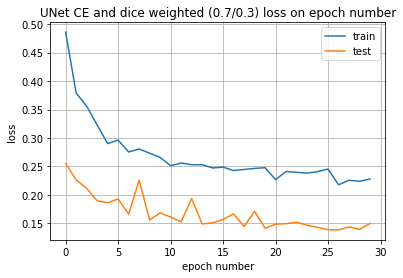

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('UNet CE and dice weighted (0.7/0.3) loss on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('loss')
ax.plot(list(range(num_epoch)), unet_ce_dice_train_loss_on_epoch, label='train')
ax.plot(list(range(num_epoch)), unet_ce_dice_test_loss_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

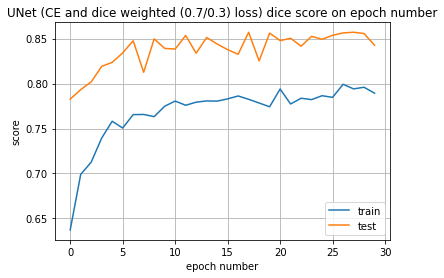

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('UNet (CE and dice weighted (0.7/0.3) loss) dice score on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('score')
ax.plot(list(range(num_epoch)), unet_ce_dice_train_metric_on_epoch, label='train')
ax.plot(list(range(num_epoch)), unet_ce_dice_test_metric_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

Предсказания UNet с взвешенной суммой CE loss и dice loss

[]

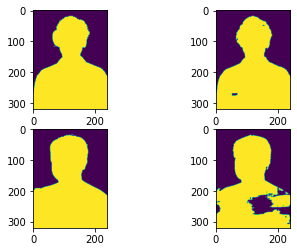

In [ ]:
unet_ce_dice.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_data_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = unet_ce_dice(inputs)
    preds = torch.sigmoid(preds)
    pred1 = (torch.squeeze(preds[0].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label1 = labels[0].cpu().data.numpy()
    pred2 = (torch.squeeze(preds[1].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label2 = labels[1].cpu().data.numpy()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(label1)
    ax2.imshow(pred1)
    ax3.imshow(label2)
    ax4.imshow(pred2)
plt.plot()

## LinkNet

Реализуем архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.
 
https://arxiv.org/pdf/1707.03718.pdf
 
Обучим сеть и проведём анализ согласно предыдущему пункту.

In [ ]:
class LinkNetDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()
 
        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(left + x))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class LinkNetDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()
 
        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', LinkNetDecoderBlock(num_filters * 2**i))
 
    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LinkNetDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )
 
    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Обучите LinkNet. Сравним LinkNet и Unet по качеству работы. Сделаем выводы. 

In [ ]:
lr = 1e-4
weight_decay = 0
num_epoch = 30
 
linknet_ce = LinkNet()
optimizer_linknet_ce = optim.Adam(linknet_ce.parameters(), lr=lr, weight_decay = weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
 
start_time = time.time()
linknet_ce_train_loss_on_epoch, \
  linknet_ce_train_metric_on_epoch, \
  linknet_ce_test_loss_on_epoch, \
  linknet_ce_test_metric_on_epoch = \
    train(linknet_ce, train_data_loader, test_data_loader, \
          optimizer_linknet_ce, criterion, val_criterion, num_epoch, device)
linknet_ce_fitting_time = time.time() - start_time

epoch: 0, train/test loss: 0.5159219529698876/0.2630205973982811, train/test metric: 0.6372608879909796/0.7663987800478935
epoch: 1, train/test loss: 0.4023079096394427/0.27052767015993595, train/test metric: 0.7020954165388557/0.75047317892313
epoch: 2, train/test loss: 0.3696147906867897/0.2652344834059477, train/test metric: 0.711595925338128/0.7886239290237427
epoch: 3, train/test loss: 0.3605995193562087/0.2294512279331684, train/test metric: 0.7088734603980008/0.7753564193844795
epoch: 4, train/test loss: 0.33180859509636373/0.20860848762094975, train/test metric: 0.7295106737052693/0.8167585581541061
epoch: 5, train/test loss: 0.3207747653564986/0.1912001147866249, train/test metric: 0.7402737798059688/0.8194373399019241
epoch: 6, train/test loss: 0.302662874407628/0.2109324373304844, train/test metric: 0.7487946985399022/0.7870534509420395
epoch: 7, train/test loss: 0.2912563223610906/0.16747128684073687, train/test metric: 0.7470673086012111/0.8355137258768082
epoch: 8, train/

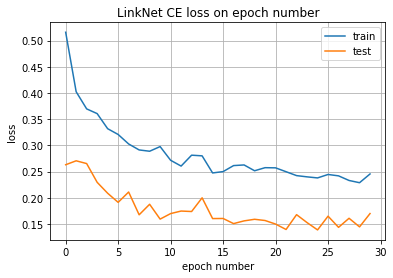

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LinkNet CE loss on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('loss')
ax.plot(list(range(num_epoch)), linknet_ce_train_loss_on_epoch, label='train')
ax.plot(list(range(num_epoch)), linknet_ce_test_loss_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

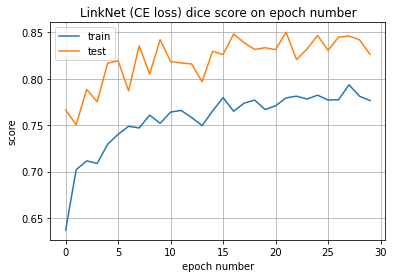

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LinkNet (CE loss) dice score on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('score')
ax.plot(list(range(num_epoch)), linknet_ce_train_metric_on_epoch, label='train')
ax.plot(list(range(num_epoch)), linknet_ce_test_metric_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

Предсказания LinkNet c CE loss

[]

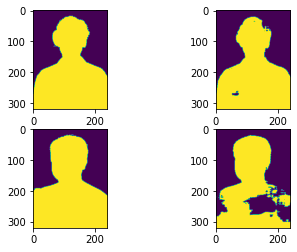

In [ ]:
linknet_ce.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_data_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = linknet_ce(inputs)
    preds = torch.sigmoid(preds)
    pred1 = (torch.squeeze(preds[0].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label1 = labels[0].cpu().data.numpy()
    pred2 = (torch.squeeze(preds[1].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label2 = labels[1].cpu().data.numpy()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(label1)
    ax2.imshow(pred1)
    ax3.imshow(label2)
    ax4.imshow(pred2)
plt.plot()

In [ ]:
lr = 5e-5
weight_decay = 1e-4
num_epoch = 30
 
linknet_dice = LinkNet()
optimizer_linknet_dice = optim.Adam(linknet_dice.parameters(), lr=lr, weight_decay = weight_decay)
criterion = DiceLoss(reduction='mean')
 
start_time = time.time()
linknet_dice_train_loss_on_epoch, \
  linknet_dice_train_metric_on_epoch, \
  linknet_dice_test_loss_on_epoch, \
  linknet_dice_test_metric_on_epoch = \
    train(linknet_dice, train_data_loader, test_data_loader, \
          optimizer_linknet_dice, criterion, val_criterion, num_epoch, device)
linknet_dice_fitting_time = time.time() - start_time

epoch: 0, train/test loss: 0.3179597539060256/0.2981180027127266, train/test metric: 0.6820402671309078/0.7018820568919182
epoch: 1, train/test loss: 0.28740783758899746/0.2981180027127266, train/test metric: 0.7125921871732263/0.7018820568919182
epoch: 2, train/test loss: 0.29549720510840416/0.2981180027127266, train/test metric: 0.7045028244747835/0.7018820568919182
epoch: 3, train/test loss: 0.2964024274226497/0.2981179989874363, train/test metric: 0.7035975990926518/0.7018820494413376
epoch: 4, train/test loss: 0.2891170954441323/0.298117995262146, train/test metric: 0.710882932824247/0.7018820270895958
epoch: 5, train/test loss: 0.29716016176868887/0.2981179989874363, train/test metric: 0.7028398689101724/0.7018820270895958
epoch: 6, train/test loss: 0.2917740088613594/0.2981180176138878, train/test metric: 0.7082260093268227/0.7018820196390152
epoch: 7, train/test loss: 0.30014195906765323/0.29811806231737137, train/test metric: 0.6998580659137053/0.7018819525837898
epoch: 8, tra

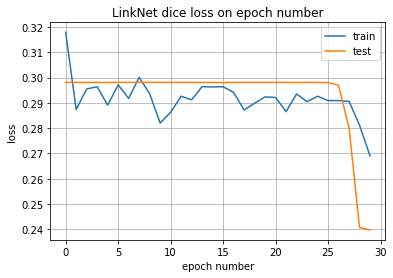

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LinkNet dice loss on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('loss')
ax.plot(list(range(num_epoch)), linknet_dice_train_loss_on_epoch, label='train')
ax.plot(list(range(num_epoch)), linknet_dice_test_loss_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

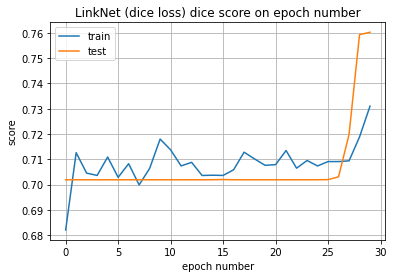

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LinkNet (dice loss) dice score on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('score')
ax.plot(list(range(num_epoch)), linknet_dice_train_metric_on_epoch, label='train')
ax.plot(list(range(num_epoch)), linknet_dice_test_metric_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

Предсказания LinkNet с dice loss

[]

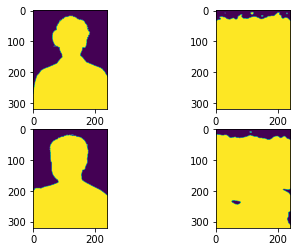

In [ ]:
linknet_dice.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_data_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = linknet_dice(inputs)
    preds = torch.sigmoid(preds)
    pred1 = (torch.squeeze(preds[0].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label1 = labels[0].cpu().data.numpy()
    pred2 = (torch.squeeze(preds[1].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label2 = labels[1].cpu().data.numpy()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(label1)
    ax2.imshow(pred1)
    ax3.imshow(label2)
    ax4.imshow(pred2)
plt.plot()

In [ ]:
lr = 1e-4
weight_decay = 0
num_epoch = 30
 
linknet_ce_dice = LinkNet()
optimizer_linknet_ce_dice = optim.Adam(linknet_ce_dice.parameters(), lr=lr, weight_decay = weight_decay)
criterion = WeightedLoss(nn.BCEWithLogitsLoss(reduction='mean'), \
                                        DiceLoss(reduction='mean'), 0.7, 0.3)
 
start_time = time.time()
linknet_ce_dice_train_loss_on_epoch, \
  linknet_ce_dice_train_metric_on_epoch, \
  linknet_ce_dice_test_loss_on_epoch, \
  linknet_ce_dice_test_metric_on_epoch = \
    train(linknet_ce_dice, train_data_loader, test_data_loader, \
          optimizer_linknet_ce_dice, criterion, val_criterion, num_epoch, device)
linknet_ce_dice_fitting_time = time.time() - start_time

epoch: 0, train/test loss: 0.46491362987195745/0.2739493418484926, train/test metric: 0.6533850733848179/0.7534513771533966
epoch: 1, train/test loss: 0.3719242613981752/0.22253074683248997, train/test metric: 0.7057192781392265/0.7981129437685013
epoch: 2, train/test loss: 0.34935835398295345/0.22328398562967777, train/test metric: 0.716450101312469/0.7848866730928421
epoch: 3, train/test loss: 0.33075491667670365/0.1867792084813118, train/test metric: 0.7348155878922519/0.8354608714580536
epoch: 4, train/test loss: 0.30519991543363123/0.19141213968396187, train/test metric: 0.7489737885839799/0.8125858753919601
epoch: 5, train/test loss: 0.29565468036076603/0.1723797284066677, train/test metric: 0.7561299152234021/0.8371811062097549
epoch: 6, train/test loss: 0.28555100542657513/0.16702477633953094, train/test metric: 0.757293271667817/0.8329689726233482
epoch: 7, train/test loss: 0.27608312534935336/0.1723922323435545, train/test metric: 0.7663210998563206/0.8309249356389046
epoch: 

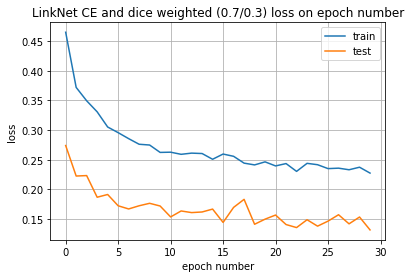

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LinkNet CE and dice weighted (0.7/0.3) loss on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('loss')
ax.plot(list(range(num_epoch)), linknet_ce_dice_train_loss_on_epoch, label='train')
ax.plot(list(range(num_epoch)), linknet_ce_dice_test_loss_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

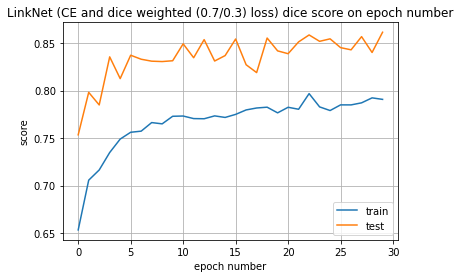

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('LinkNet (CE and dice weighted (0.7/0.3) loss) dice score on epoch number')
ax.set_xlabel('epoch number')
ax.set_ylabel('score')
ax.plot(list(range(num_epoch)), linknet_ce_dice_train_metric_on_epoch, label='train')
ax.plot(list(range(num_epoch)), linknet_ce_dice_test_metric_on_epoch, label='test')
plt.grid()
plt.legend()
plt.show()

Предсказания LinkNet с взвешенной суммой CE loss и dice loss:

[]

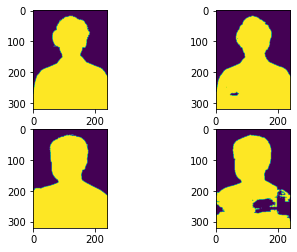

In [ ]:
linknet_ce_dice.eval()
with torch.no_grad():
    inputs, labels = next(iter(test_data_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    preds = linknet_ce_dice(inputs)
    preds = torch.sigmoid(preds)
    pred1 = (torch.squeeze(preds[0].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label1 = labels[0].cpu().data.numpy()
    pred2 = (torch.squeeze(preds[1].cpu().data, 0).numpy() > 0.5).astype('int') * 255
    label2 = labels[1].cpu().data.numpy()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(label1)
    ax2.imshow(pred1)
    ax3.imshow(label2)
    ax4.imshow(pred2)
plt.plot()

## Выводы
1. Лучшее качество сегментации показала сеть UNet с CE loss.
2. Худшее качество сегментации показала сеть LinkNet с dice loss.